# **AM 207**: Homework 4

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday April 7th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW4.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW4.tar.gz or AM207_YOURNAME_HW4.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/home/kevin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Problem 1: Bayesian Models for Yelp Check-in Data

Below is a visualization of Yelp checkins on a portion of the Las-Vegas strip. The goal of this problem is to model an intensity surface on this map which is indicative of the propensity of an individual to check in at a particular location.
<img src="Rplot.jpeg">
Such an intensity surface is very valuable for example to decide what would be good places to open another casino or restaurant. 

The first hierarchical model will use a conjugate prior (and hence we can compute an analytical solution) and the second will use a non-conjugate set up with correlated priors.

### Data description
We have M grid squares of width $w=0.005$. The variable `checkins` contains M checkin values, one for each square. The variable `X` contains the coordinates of the center of each square. This data set is a subset of the map shown above.

In [2]:
#load checkins
checkins = np.genfromtxt('checkin_counts.csv', delimiter=',')
#load latitude and longitude values associated with each count value
X = np.genfromtxt('X.csv', delimiter=',')
#set M to the length of the checkins vector
M = checkins.size
#set grid width w to be .0005 latitude/longitude
w = .0005
print checkins.shape

(2000,)


### Conjugate Model
In the first model, we assume that a map (i.e., the Las Vegas strip) is discretized into $M$ grid squares of width $w$, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. (That is, the check-ins follow a Poisson process conditioning on the $\lambda$, and $\lambda \in \mathbb{R}^m$ is the intensity surface we would like to infer.) Furthermore $\lambda_i$ is drawn from a conjugate $Gamma(\alpha, \beta)$ distribution. The $Y_i$ are conditionally independent on $\lambda_i$, and $\lambda_i$ is indepndent of $\lambda_j$ for $i \neq j$.

Derive the posterior distribution $p(\lambda_i|Y_i)$ for this model analytically as a function of hyperparameters $\alpha$ and $\beta$. Use the posterior mean as an estimate for $\lambda_i$, and then plot the posterior mean of $\lambda_i$ on a grid for varying values of $\alpha$ and $\beta$. Discuss if this model leads to a useful intensity surface, and how the usefulness of the result is influenced by the choice of $\alpha$ and $\beta$.

### Non-Conjugate Model
Now let's move on to a slightly more complicated model. Again assume that the grid is discretized into $M$ cells of the same area, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. However there is a twist: we assume $\lambda_i$ is equivalent to $exp[\alpha+Z_i]$ where $Z \in \mathbb{R}^{M}$ is drawn from a multivariate normal $MVN(0,\Sigma)$ distribution, where $\Sigma$ comes from a squared exponential kernel, and $\alpha$ is drawn according to a N(0,1) distribution. In this way, the $\lambda_i$ for distinct cells are no longer independent but are correlated.(If you'd like to delve deeper, this process is called a "Log-Guassian Cox process".)

Describe what the meaning of $\alpha$ and $\Sigma$ is for this model. 

We model $\Sigma$ using a square exponential kernel such that the covariances decay exponentially quickly as points get further apart from each other. That is $$\Sigma_{ij} = Exp[-||X_i-X_j||_2^2/\phi]$$

Where $X_i$ and $X_j$ are the $ith$ and $jth$ rows of $X$ respectively. Describe in which way the choice of $\phi$ influences the kernel. By default, use $\phi = .00001$. 

To simplify your code, consider the prior parameters/latent variables ($\alpha$, $Z$) jointly as a vector in $\mathbb{R}^{M+1}$. Determine the covariance matrix for the multivariate normal prior on this vector and store it all together in a variable called Sigma. Give a short explanation why we can do this. 
When you implement the computation of $Sigma$, small numerical instabilities can lead to a covariance matrix that is not positive-semidefinite. You can check this by attempting a Cholesky decomposition of $\Sigma$ with numpy. If it throws an error, you can add a small offset to the diagonal of the matrix to help with numerical stability. 

We will provide you with code for an elliptical slice sampler for this problem. This sampling method was directly devloped for problems like this and we will discuss it later in class. For now it is sufficient for you to use the code, without neccessarily understanding it. Use the provided sampler to estimate the posterior mean for this non-conjugate model. In addition implement the model also in PYMC or vanilla Metropolis Hastings, and compare the result. 

Finally discuss the differences in results from the conjugate and the non-conjugate model and which one you would prefer. 

### Helper functions

Here is some code that should be useful:

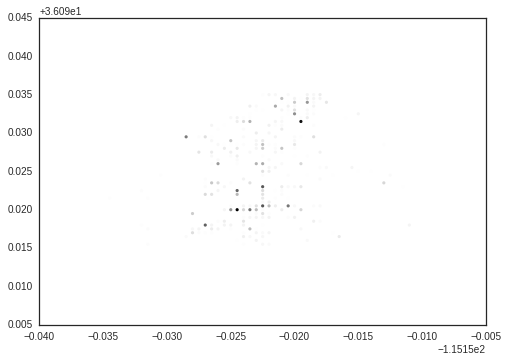

(2000,)


In [3]:
# This function takes a vector of M intensities and plots it according to the coordinates in `X`.
# The values of the intensities are normalized to [0,1] and darker means higher values
def plot_checkins(checkins):
    colors = checkins / np.double(np.max(checkins))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()
    
plot_checkins(checkins)
print checkins.shape

In [4]:
#elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N

    
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
    print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        f = mcmc_samples[i-1,:]
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

## Part 1: conjugate model

The Poisson likelihood is given by $$P(\lambda_i|Y_i) = \frac{e^{-\lambda_i}\lambda_i^{Y_i}}{Y_i!}$$
The conjugate prior is given by a gamma distribution $$ P(\lambda_i) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda_i^{\alpha-1}e^{-\beta\lambda_i} $$.The conjugate posterior is $$p(\lambda_i|Y_i) = Gamma(Y_i + \alpha, 1+ \beta)$$

Next we estimate the expected value of $\lambda$. $$E[P(\lambda_i|Y_i)] = \frac{1}{1+\beta}Y_i + \frac{\alpha}{1+\beta}$$ The functional form of gamma distribution and mean are taken from wikipedia. 

Finally we show $\lambda_i$ as a function of $\alpha$ and $\beta$ for several value of $Y_i$. Note that we assume Poisson process so disjoint intervals have independent probability distribution. The probability of visit in each disjoint area is naturally uncoupled. 

We know that Poisson distribution has mean of $\lambda$. Hence, we expect the plots of $\lambda$ to be very similar to the distribution of data Y. In the attached code we show 2 types of plots. The color map shows the value of $\lambda$ as functions of $\alpha$ and $\beta$ for fixed value of $Y_i$. Here $\lambda$ increases as $\alpha$ increases and decreases by $\beta$ increases. Here $\alpha$ is the exponential rate and $\beta$ is the scale. Intuitively, to have small effect on mean estimation, we want to set $\beta$ to be around 0 and $\alpha$ small. For large $Y_i$ the effect of $\alpha$ is small. 

The second type of plot shows the $\lambda$ map as functions of different input of $\beta$ and $\alpha$. As we set $\beta$ around 0 and $\alpha$ around 1 then the distribution of $\lambda$ mean resembles the input data. As we increase $\beta$ and $\alpha$, the distribution start to deviate from the input data. 

This conjugate model is not very useful. For small $\alpha$ and $\beta$, the estimation of mean is very close to the input data. For large $\beta$ and $\alpha$, the distribtuion becomes more homogeneous. This is shown in the attached plots. 


## Part 2: non-conjugate model

In the second part we use a non-conjugate model to account for the relationship of distance. Here we are given that $Y_i$ ~ $Poi(\lambda_i w^2)$, and $\lambda_i=exp(\alpha+Z_i)$. $Z_i \in R^M$ and $Z_i $ ~ $MVN(0,\Sigma)$. Also we are given that $\alpha$ ~ $N(0,1)$. Since $\alpha$ and $\Sigma$ are independent and both have 0 mean, we can concatenate them into a large matrix $\Sigma^* \in R^{M+1}$ such that

$$ \Sigma^* = \left( 
\begin{array}{cc}
1 & 0... \\
0... & \Sigma
\end{array}
\right ) $$

We are given that $$\Sigma_{ij} = Exp[-||X_i-X_j||_2^2/\phi]$$ and the ESS sampling function. Here the log_likelihood function is given by: 

$$ log(l) = \sum_{i=1}^M log\_Poi(Y_i|w^2\lambda_i)$$

We vectorize logpmf to improve the sampling speed. Overall, we find the ESS sampler to be fairly fast compared to pymc implementation. Please refer to the attached code for implementation details. We compare the distribution $\lambda_i$ versus $Y_i$. Note that here the sampled mean of $\lambda$ is more smooth. The smoothness is contributed by the $\Sigma$ matrix, which makes neighboring grid cell more correlated. 

I find this approach to be a better model because it leverages on the knowledge of distance and returns a smoother distribution. This smoother distribution can be used later for inference or optimization purposes. If we use the conjugate model, then the distribution is singular and any gradient-based searching methods may not work on that distribution.

Finally, we implement the identical non-conjugate model in pymc and find its sampling speed to be much slower than the ESS implementation. Please refer to the attached code for implementation details.
 

In [ ]:
## conjugate model for expectation value of lambda
alpha,beta = np.meshgrid(np.linspace(0,10,101),np.linspace(0,10,101))

#array of Y values
Y = np.array([0,1,2,3,4,5])
expected_val = np.zeros((Y.shape[0],alpha.shape[0],alpha.shape[1]))
for i in xrange(expected_val.shape[0]):
    for j in xrange(expected_val.shape[1]):
        for k in xrange(expected_val.shape[2]):
            expected_val[i,j,k] = 1 / (1+ beta[j,k]) * Y[i] + alpha[j,k] / (1+ beta[j,k])

fig = plt.figure(figsize=(20,10))

#generate colormap for fixed Y_i
for i in xrange(Y.shape[0]):
    plt.subplot(2,3,i+1)
    plt.imshow(expected_val[i,:,:], extent=(alpha.min(), alpha.max(), beta.max(), beta.min()), \
           interpolation='nearest', cmap=matplotlib.cm.gist_rainbow, vmin = 0, vmax = 20)
    plt.xlabel('alpha')
    plt.ylabel('beta')
    title_string= 'Yi = ', i
    plt.title(title_string)
    plt.colorbar()

#next, plot the entire map
Y = checkins
fig1 = plt.figure(figsize =[12,8])

#case 1: alpha =0, beta=0
alpha = 0.0; beta = 0.0
poisson_l = np.zeros(Y.shape,dtype = 'float')
poisson_l = 1/ (1+beta) * Y + alpha / (1+beta)
plt.title('alpha =1.0 beta=1.0')
plot_checkins(poisson_l)

#case 2: alpha = 10, beta=1
fig2 = plt.figure(figsize =[12,8])
alpha = 10; beta = 1.0
poisson_l = np.zeros(Y.shape,dtype = 'float')
poisson_l = 1/ (1+beta) * Y + alpha / (1+beta)
plt.title('alpha =10 beta=1.0')
plot_checkins(poisson_l)

#case 3: 
fig3 = plt.figure(figsize =[12,8])
alpha = 1; beta = 0.5
poisson_l = np.zeros(Y.shape,dtype = 'float')
poisson_l = 1/ (1+beta) * Y + alpha / (1+beta)
plt.title('alpha =1.0 beta=0.5')
plot_checkins(poisson_l)

#case 4:
fig4 = plt.figure(figsize =[12,8])
alpha = 2; beta = 0.5
poisson_l = np.zeros(Y.shape,dtype = 'float')
poisson_l = 1/ (1+beta) * Y + alpha / (1+beta)
plt.title('alpha =2 beta=0.5')
plot_checkins(poisson_l)


In [8]:
#part 2 -nonconjugate prior

#define poisson distribution
def poisson_dist(l,x):
    val = l**x * np.exp(-l) / (0.0+ scipy.misc.factorial(x))
    return val

#define log_likelihood function
def log_likelihood(f,Y):
    log_likelihood_vectorized = np.sum(scipy.stats.poisson.logpmf(Y,w**2*np.exp(f[0]+f[1:])))
    
    return log_likelihood_vectorized
    
#define phi
phi = 0.00001
Y = checkins
M = Y.size

#to construct extend matrix Sigma
Sigma = np.zeros((M+1,M+1),dtype = 'float')
Sigma[0,0] = 1.0 # this term considers the alpha contribution

diagonal_offset = 1e-14; # term to ensure numerical stability

for i in range(1,M+1):
    for j in range(1,M+1):
        #Sigma[i,j] = np.exp(-np.sum((X[i-1,:]-X[j-1,:])**2)/phi)
        Sigma[i,j] = np.exp(-((X[i-1,0]-X[j-1,0])**2+(X[i-1,1]-X[j-1,1])**2)/phi)
        if i == j:
            Sigma[i,j] += diagonal_offset

#sample using elliptical slice sampler
N_mcmc = 150000
N_dim = M+1
burn_in = 10
ess_sample = ess(Y,Sigma,log_likelihood,N_mcmc,burn_in,N_dim)

#find sample mean
'''
l_sample = ess_
l_sample = ess_sample[]



mean_ess_sample = np.mean(ess_sample,axis = 0)
alpha = mean_ess_sample[0]
lambda_sample = mean_ess_sample[0:-1]
mean_ess_sample = np.reshape(lambda_sample,(N_dim-1,))

mean_l_sample = np.exp(mean_ess_sample + alpha)
plot_checkins(mean_l_sample)

print mean_l_sample
'''

running elliptical slice sampling...


'\nl_sample = ess_\nl_sample = ess_sample[]\n\n\n\nmean_ess_sample = np.mean(ess_sample,axis = 0)\nalpha = mean_ess_sample[0]\nlambda_sample = mean_ess_sample[0:-1]\nmean_ess_sample = np.reshape(lambda_sample,(N_dim-1,))\n\nmean_l_sample = np.exp(mean_ess_sample + alpha)\nplot_checkins(mean_l_sample)\n\nprint mean_l_sample\n'

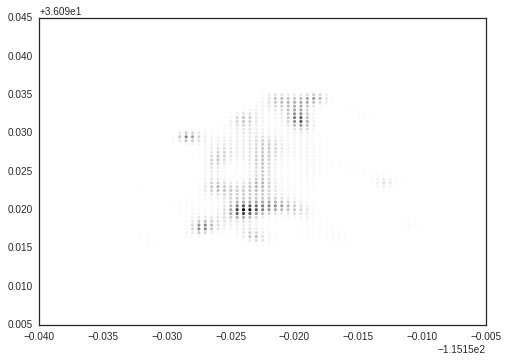

(2000,)


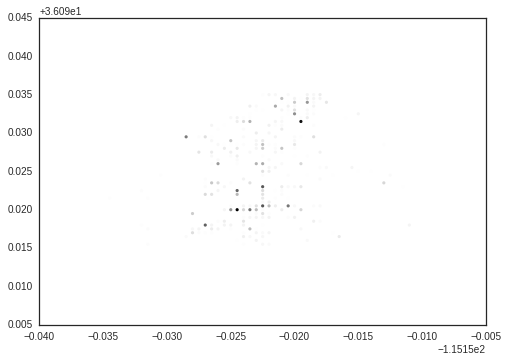

In [9]:
#plot solution from ess sampling
#print ess_sample.shape
l_sample = np.zeros((ess_sample.shape[0],ess_sample.shape[1]-1),dtype='float')
for i in range(ess_sample.shape[0]-1):
    l_sample[i,:] = np.exp(ess_sample[i,1:]+ess_sample[i,0])

#print l_sample.shape
    
l_sample_mean = np.mean(l_sample[-10000:,:],axis=0)
#plt.plot(ess_sample[:,0])
#print np.max(l_sample_mean*w**2)
#print np.max(Y)
plot_checkins(l_sample_mean)

print l_sample_mean.shape
#print mean_l_sample

fig2 = plt.figure()
plot_checkins(Y)
    



In [24]:
#sample posterior from pymc
print Sigma.shape
#construct alpha
alpha = pm.Normal('alpha',0,1)

#construct Z
Z = pm.MvNormalCov('Z',mu = np.zeros(M),C = Sigma[1:,1:])

@pm.observed
def pymc_log_likelihood(value = Y, a =alpha, z = Z, width = w):
    log_prob = np.zeros(M,dtype ='float')
    
    for i in range(M):
        #print a, z[i]
        log_prob[i] += pm.poisson_like(Y[i],(np.exp(a+z[i])*width**2))
    
    
    return np.sum(log_prob)

model = pm.Model([alpha,Z,pymc_log_likelihood])
p_mcmc = pm.MCMC(model)
p_mcmc.sample(iter = 50000, burn = 100, thin = 10)
'''
@pm.observed
def pymc_log_likelihood(ind = 0, value = Y, a =alpha, z = Z, width = w):
    #log_prob = np.zeros(M,dtype ='float')
    
    #for i in range(M):
    #print a, z[i]
    log_prob = pm.poisson_like(Y[ind],(np.exp(a+z[ind])*width**2))
    
    
    return log_prob

num_iter = 5000
pymc_sample_l = np.zeros((num_iter,M),dtype = 'float')

model = pm.Model([alpha,Z,pymc_log_likelihood])
p_mcmc = pm.MCMC(model)
p_mcmc.sample(iter = num_iter, burn = 100, thin = 10)

for i in range(M):
    model = pm.Model([alpha,Z,pymc_log_likelihood(i)])
    p_mcmc = pm.MCMC(model)
    p_mcmc.sample(iter = num_iter, burn = 100, thin = 10)
    pymc_sample_l[:,i] = np.exp(alpha.trace() + Z.trace()[:,i])
'''


(2001, 2001)
 [-----------------100%-----------------] 50000 of 50000 complete in 5250.9 sec

"\n@pm.observed\ndef pymc_log_likelihood(ind = 0, value = Y, a =alpha, z = Z, width = w):\n    #log_prob = np.zeros(M,dtype ='float')\n    \n    #for i in range(M):\n    #print a, z[i]\n    log_prob = pm.poisson_like(Y[ind],(np.exp(a+z[ind])*width**2))\n    \n    \n    return log_prob\n\nnum_iter = 5000\npymc_sample_l = np.zeros((num_iter,M),dtype = 'float')\n\nmodel = pm.Model([alpha,Z,pymc_log_likelihood])\np_mcmc = pm.MCMC(model)\np_mcmc.sample(iter = num_iter, burn = 100, thin = 10)\n\nfor i in range(M):\n    model = pm.Model([alpha,Z,pymc_log_likelihood(i)])\n    p_mcmc = pm.MCMC(model)\n    p_mcmc.sample(iter = num_iter, burn = 100, thin = 10)\n    pymc_sample_l[:,i] = np.exp(alpha.trace() + Z.trace()[:,i])\n"

(4990, 2000)


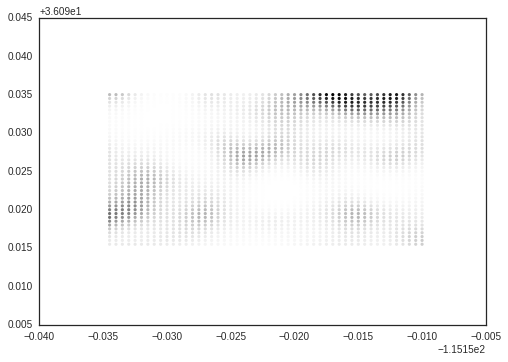

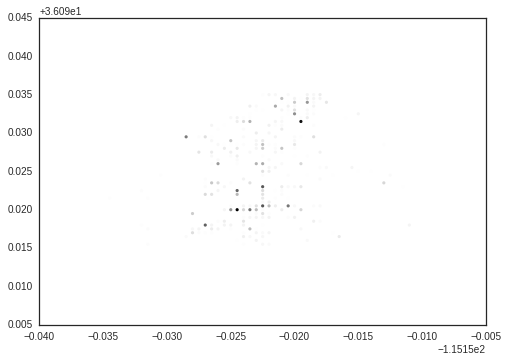

In [31]:
pymc_l = np.zeros(Z.trace().shape)
print Z.trace().shape
for i in range(Z.trace().shape[0]):
    pymc_l[i,:] = np.exp(alpha.trace()[i] + Z.trace()[i,:])
    
mean_pymc_l = np.mean(pymc_l[100:5500,:],axis=0)

fig1 = plt.figure()
plot_checkins(mean_pymc_l)

fig2 = plt.figure()
plot_checkins(Y)

# Problem 2: Point Matching

In this problem you are given two point clouds `points1` and `points2`. Your task is to estimate an affine transformation which can map the points of `points1` onto the points of `points2`. Unfortunately you don't know which points from the two point sets correspond to each other.

We are modeling the correspondences in a correspondence matrix $M$, which is of size $n_1 \times n_2$ where $n_i$ is the number of points in point set $i$. $M_{ij}=1$ indicates that point $x_i$ from `points1` and $y_j$ from `points2` correspond to each other. Each point is only allowed to have one correspondence. So for all $i$ we have $\sum_l^{n_2} M_{il} = 1$ 

The likelihood for this problem is:

$$ \prod_i^{n_1} \prod_j^{n_2} \varphi_{0,\sigma}\left(||Ax_i - y_j||^2\right)^M_{ij} $$

where $\varphi_{0,\sigma}$ is a normal distribution with mean 0 and variance $\sigma^2$. We use $\sigma^2 = 0.1$ as a default for this problem. 

Note: The $M_{ij}$ is not rendering correctly in my notebook. The indices $ij$ are supposed to belong to $M$. Please look at the latex code for clarification.

Estimate the affine transform $A$ that matches the two point sets using expectation maximization and simulated annealing and compare the results. What are the strength of each algorithm? Which one would you prefer in which scenario?

Here are some hints that should be useful:
* The M-step of the problem will be a weighted least squares solution. 
* To use linear algebra to solve the M step it is useful to extend the point matrices to contain all possible pairwise correspondence pairs. 
* The weights for the weighted least squares should be updated in your E-step

## Solution
Here we implementation both expectation maximization and simulated annealing to solve the points matching problem. 

### Expectation maximization

We solve this problem as a linear algebra problem. First we define several quantities:

$X' \in  R^{n_1  n_2 \times n_1  n_2}$ and $Y' \in  R^{n_1  n_2 \times n_1  n_2}$ are replicated points1 and points2 such that every point corresponds to every other point. We define the probability matrix G to be $G_{ij} = P(x_i,y_j) \propto \varphi_{0,\sigma}(||Ax_i - y_j||^2)\ $ which implies $x_i$ correponds to $y_j$, $G \in R^{n_1\times n_2}$. G is the weighted matrix. We normalize each row such that the rowsum equals 1. Next we extend G to be a sparse diagonal matrix such that all elements of G are put to the diagonal entries of G': $G' \in {R^{n_1 n_2 \times n_1 n_2}}$. 

In the maximization step, we solve for a matrix A that maximizes likelihood assuming the current pseudo-label matrix G is correct. We use the numerical least square formula: 

$A = (X'^TG'X')^{-1}X'^TG'Y'$. For implementation details please refer to the attached code. 

In the expectation step, we update the pseudo-label matrix G' assuming the new A is the best. That is we compute  $$G_{ij} = \varphi_{0,\sigma}(||Ax_i - y_j||^2)\ $$ and then normalize every row.

This expectation maximization process guarantees that we converge to a local maximum. We set the stoppiong criteria to be if the change of log_likelihood is smaller than 1e-15. 

From visual inspection we find the solution A gives quiet close transformation. 

### Simulated annealing

We can also solve for this problem through simulated annealing. Here the variance is very small such that incorrect label can easily make the log_likelihood approach negative infinity. To improve the convergence speed, we make the simplifying assumption that the label is deterministically related to a transformed point's closed neighbor. 

Consequently, we only need to use simulated annealing to solve for 3 parameters: tx, ty, and $\alpha$. Here we define the transformation matrix A to be: 

$$ A = \left( 
\begin{array}{cc}
\cos(\alpha) & sin(\alpha) & 0\\
-\sin(\alpha) & \cos(\alpha) & 0 \\
tx   & ty   & 1
\end{array}
\right ) $$

In each step we set obtain a new proposed $\alpha$ , $tx$ and $ty$ based on the current temperature. Then we calculate the proposed matrix new_A. We use this matrix to calculate the proposed label $new\ z$. Finally we use the new z and new A to calculate the new log likelihood. If the log likelihood increases, then we accept. If the log likelihood decreases, then we accept with a probability accordingly to $exp(\triangle \ log\_likelihood / \ temperature)$. For implementation details please refer to the attached code. This simplification avoids using simulated annealing to solve for the labels, which is a very inefficient since we have a large number of points. Consequently, we achieve convergence after 100 iterations. 

If we use simulated annealing to also solve for the labels, then the algorithm does not converge after 10000 iterations. This implies the unless reasonable simplications can be made, maximization expectation can be much faster to solve problems with a large data set and the need of a label per data point. 

Please refer to the attached code for implementation details. 


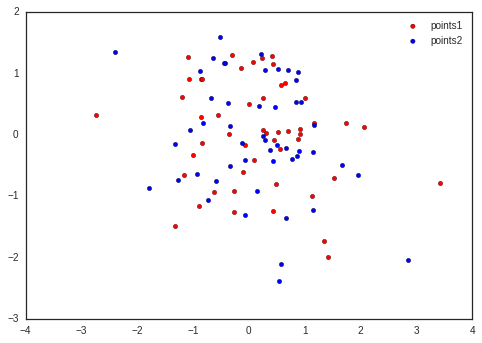

In [26]:
points1 = np.array([[-0.855,  0.905,  1.   ],[ 1.417, -1.999,  1.   ],[-0.896, -1.166,  1.   ],[-0.114, -0.604,  1.   ],
                    [ 2.055,  0.131,  1.   ],[ 0.694,  0.056,  1.   ],[-1.318, -1.495,  1.   ],[ 0.479, -0.799,  1.   ],
                    [-1.081,  0.91 ,  1.   ],[-0.273, -1.258,  1.   ],[ 1.733,  0.188,  1.   ],[ 0.65 ,  0.848,  1.   ],
                    [-0.007,  0.507,  1.   ],[-0.262, -0.922,  1.   ],[-0.14 ,  1.078,  1.   ],[ 0.239,  1.246,  1.   ],
                    [ 0.528,  0.036,  1.   ],[ 0.31 ,  0.025,  1.   ],[-2.734,  0.325,  1.   ],[ 1.014,  0.597,  1.   ],
                    [-0.839, -0.137,  1.   ],[ 0.924,  0.012,  1.   ],[ 0.09 , -0.407,  1.   ],[ 0.433, -1.236,  1.   ],
                    [ 1.345, -1.731,  1.   ],[-0.362,  0.012,  1.   ],[ 0.416,  1.279,  1.   ],[ 1.165,  0.185,  1.   ],
                    [ 0.446, -0.088,  1.   ],[-1.006, -0.335,  1.   ],[ 0.072,  1.188,  1.   ],[ 0.25 ,  0.076,  1.   ],
                    [ 1.525, -0.699,  1.   ],[ 0.574,  0.805,  1.   ],[-1.171, -0.655,  1.   ],[ 0.873, -0.067,  1.   ],
                    [-0.306,  1.291,  1.   ],[-0.07 , -0.174,  1.   ],[-1.088,  1.27 ,  1.   ],[-0.864,  0.295,  1.   ],
                    [-0.845,  0.914,  1.   ],[ 1.136, -1.001,  1.   ],[-0.55 ,  0.328,  1.   ],[-1.201,  0.621,  1.   ],
                    [-0.617, -0.941,  1.   ],[ 0.438,  1.147,  1.   ],[ 0.252,  0.593,  1.   ],[ 3.42 , -0.792,  1.   ],
                    [ 0.923,  0.096,  1.   ],[ 0.563, -0.235,  1.   ]])

points2 = np.array([[-0.131, -0.134,  1.   ],[-2.402,  1.347,  1.   ],[ 0.137, -0.921,  1.   ],[ 0.581, -2.113,  1.   ],
                    [ 0.283,  1.049,  1.   ],[-0.734, -1.058,  1.   ],[ 0.26 , -0.025,  1.   ],[ 0.296, -0.095,  1.   ],
                    [ 0.211,  1.31 ,  1.   ],[ 0.874,  1.023,  1.   ],[-0.336, -0.515,  1.   ],[ 0.859, -0.343,  1.   ],
                    [-0.073, -1.308,  1.   ],[-1.058,  0.075,  1.   ],[ 0.544, -2.389,  1.   ],[-0.827,  0.195,  1.   ],
                    [ 0.666, -1.36 ,  1.   ],[ 0.698,  1.059,  1.   ],[-1.274, -0.734,  1.   ],[-0.52 ,  1.589,  1.   ],
                    [ 1.141, -1.229,  1.   ],[ 0.89 , -0.265,  1.   ],[ 0.521,  1.07 ,  1.   ],[-0.651,  1.254,  1.   ],
                    [-0.686,  0.603,  1.   ],[ 0.502, -0.169,  1.   ],[ 0.925,  0.535,  1.   ],[-0.93 , -0.634,  1.   ],
                    [-0.33 ,  0.149,  1.   ],[-0.431,  1.168,  1.   ],[ 0.43 , -0.433,  1.   ],[ 1.949, -0.665,  1.   ],
                    [-0.872,  1.033,  1.   ],[ 0.378, -0.252,  1.   ],[-1.79 , -0.877,  1.   ],[ 0.781, -0.396,  1.   ],
                    [ 1.147, -0.275,  1.   ],[-0.073, -0.41 ,  1.   ],[ 1.673, -0.489,  1.   ],[-1.332, -0.157,  1.   ],
                    [-0.444,  1.163,  1.   ],[ 0.459,  0.452,  1.   ],[ 0.843,  0.892,  1.   ],[ 0.662, -0.214,  1.   ],
                    [ 0.838,  0.524,  1.   ],[ 0.188,  0.471,  1.   ],[ 1.166,  0.164,  1.   ],[-0.595, -0.751,  1.   ],
                    [-0.382,  0.514,  1.   ],[ 2.857, -2.04 ,  1.   ]])

plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.legend()
plt.show()

initialization is [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
solution is:  [[  8.92643238e-01  -3.84544260e-01  -2.77555756e-17]
 [  3.54099800e-01   8.89426828e-01   0.00000000e+00]
 [  2.25276745e-02   5.03364301e-03   1.00000000e+00]] 
 label is [29 14 18 10 31 43 34  2 23  5 38 26 45 47  4 17 25  7  1 46 15 11 37 12  3
 28  9 36 33 13 22  6 20 44 39 35  8  0 19 24 29 16 48 32 27 42 41 49 21 30]


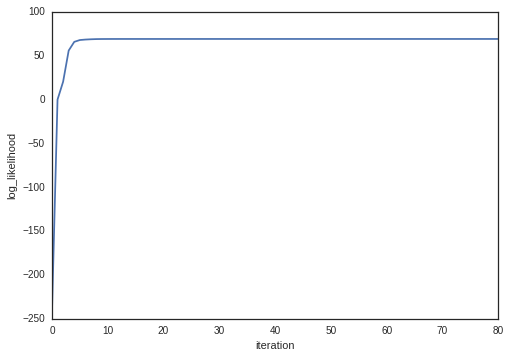

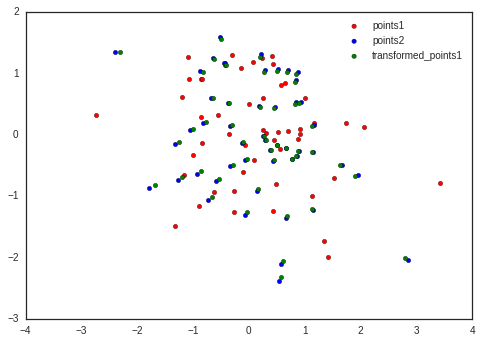

In [27]:
# test
'''
points1 = np.array([[0.1,0.0,1], [0.1,0.1,1],  [0,0.1,1]])
points2 = np.array([[-0.1,0.0,1],[-0.1,-0.1,1],[0,-0.1,1]])

plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.legend()
plt.show()
'''

#extend points
def replicate_pts(points1,points2):
    points1_rep = np.empty((points1.shape[0]*points2.shape[0],3),dtype='double')
    points2_rep = np.empty((points1.shape[0]*points2.shape[0],3),dtype='double')
    for i in xrange(points1.shape[0]):
        for j in xrange(points2.shape[0]):
            points1_rep[j + i * points1.shape[0],:] = points1[i,:]
            points2_rep[j + i * points2.shape[0],:] = points2[j,:]
            
    return points1_rep,points2_rep



# solve for pseudo-label G
def E_step(A, likelihood_fn, points1_rep, points2_rep):
    #compute distance
    distance_sq = np.sum((np.dot(points1_rep,A) - points2_rep)**2,axis=1)
    
    #compute associated probability
    G =likelihood_fn.pdf(distance_sq)
    
    #initialize log_likelihood
    log_likelihood = 0.0;
    
    #normalize
    num_pt = np.int(np.sqrt(points1_rep.shape[0]))
    G = G.reshape((num_pt,num_pt))
    indices = np.zeros(num_pt,dtype = 'int')
    for i in xrange(num_pt):
        #print np.log((G[i,:]))
        log_likelihood += np.log(np.max(G[i,:]))
        indices[i] = np.argmax(G[i,:])
        G[i,:] = G[i,:] / (np.sum(G[i,:]))
                
    G = G.reshape(num_pt*num_pt)
    #assert(0)
    return np.diag(G),log_likelihood, indices

def M_step(points1_rep,points2_rep,G_diag):
    M1 = np.dot(np.dot(points1_rep.T,G_diag),points1_rep)
    M2 = np.dot(np.dot(points1_rep.T,G_diag),points2_rep)
    return np.dot(np.linalg.inv(M1),M2)

#implementation of expectation maximization
if __name__ == '__main__':
    
    #define normal distribution with mu = 0, sigma^2 = 0.1
    #?scipy.stats.norm
    normal = scipy.stats.norm(0,0.1)
    #print normal.pdf([0,0.1])
    
    #extend pt1 and pt2
    points1_rep, points2_rep = replicate_pts(points1,points2)
    
    #print points1_rep, points2_rep
    
    #intialize A as the identity matrix
    A = np.eye(3, dtype='double')
    #alpha = 0.7
    #tx =0.0
    #ty=0.0
    #A = np.array([[np.cos(alpha), -np.sin(alpha),0.0],[np.sin(alpha),np.cos(alpha),0.0],[tx,ty,1.0]])
    print 'initialization is', A
    #Estep: update pseudo-labels
    G_diag,log_likelihood,indices = E_step(A,normal,points1_rep,points2_rep)
    
    max_iter = 100
    counter = 1
    log_likelihood_vec = np.zeros(max_iter,dtype = 'double')
    log_likelihood_vec[0] = log_likelihood
    tol = 1e-15
    error = 1
    A_old = np.zeros((3,3),dtype = 'double')
    
    #iteratively maximize likelihood
    while counter < max_iter-1 and error>tol:
        
        #debug
        #print G_diag
        #G_diag = np.diag([1,0,0,0,1,0,0,0,1])
    
        #Mstep: update matrix A
        A  = M_step(points1_rep,points2_rep,G_diag)
        error = np.sum(np.sum(np.abs(A-A_old)))
        
        #E_step 
        G_diag,log_likelihood,indices = E_step(A,normal,points1_rep,points2_rep)
        
        #increment counter
        counter+=1
        log_likelihood_vec[counter] = log_likelihood
        
        #save A
        A_old = A
        
    #print result
    print 'solution is: ', A, '\n label is' , indices
    
    #display likelihood history
    plt.plot(log_likelihood_vec[0:counter])
    plt.xlabel('iteration')
    plt.ylabel('log_likelihood')
    
    #plot solution
    tpoints1 = np.dot(points1, A)
    fig2 = plt.figure(2)
    plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
    plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
    plt.scatter(tpoints1[:,0], tpoints1[:,1], c='g', label='transformed_points1')
    plt.legend()

simulated annealing solution 
current iteration is  1000 out of  2000
current iteration is  2000 out of  2000
itol
simulated annealing solution is:  [[ 0.92673746 -0.37570957  0.        ]
 [ 0.37570957  0.92673746  0.        ]
 [ 0.00563197 -0.00952236  1.        ]] with value =  63.7672529947


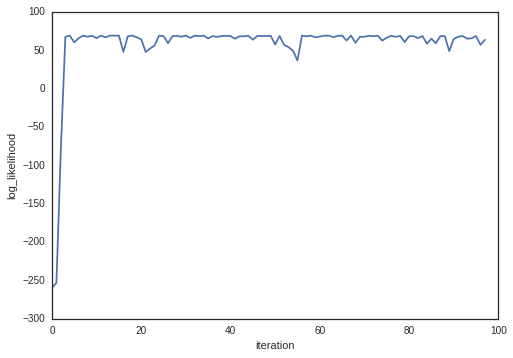

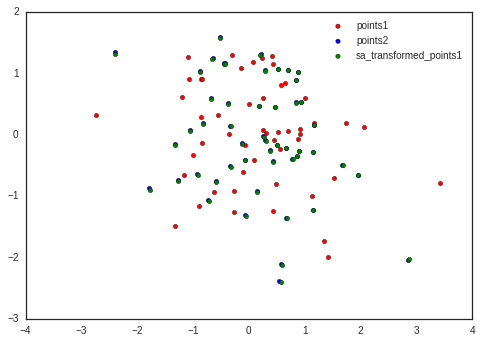

In [69]:
#simulated annealing implementation

# log_likelihood
def log_likelihood(A, Z, likelihood_fn, points1, points2):
    #compute distance
    distance_sq = np.sum((np.dot(points1[Z,:],A) - points2)**2,axis=1)
    
    #print distance_sq
    
    #compute log_likelihood
    #print distance_sq
    #print np.log(likelihood_fn.pdf(distance_sq))
    log_likelihood =np.sum(np.log(likelihood_fn.pdf(distance_sq)))
    
    #print log_likelihood
    #assert(0)
    return log_likelihood
    
# swap indices Z
def swap_indices(Z,num_swap,num_pt1,num_pt2):
    swp_ind = np.random.randint(0,num_pt1,num_swap)
    swp_val = np.random.randint(0,num_pt2,num_swap)
    Z[swp_ind] = swp_val
    return Z

# mutate A
def mutate_affine_transformation(alpha,tx,ty,angle_range,x_range,y_range):
    new_alpha = alpha + np.random.uniform(-angle_range,angle_range)
    new_tx = tx + np.random.uniform(-x_range,x_range)
    new_ty = ty + np.random.uniform(-y_range,y_range)
    
    return new_alpha, new_tx, new_ty

#generate affine transformation matrix
def affine_transform_matrix(alpha, tx, ty):
    #A = np.zeros((3,3),dtype = 'float')
    A = np.array([[np.cos(alpha), -np.sin(alpha),0.0],\
                  [np.sin(alpha),np.cos(alpha),0.0], \
                  [tx,ty,1.0]])
    return A

#find closest indices
def find_closest_pt_indices(points1,points2):
    indices = np.zeros(points2.shape[0],dtype = 'int')
    for i in xrange(points2.shape[0]):
        indices[i] = np.argmin((points2[i,0] - points1[:,0])**2 + (points2[i,1] - points1[:,1])**2)
        #print (points1[i,1] - points2[:,1])**2 + (points1[i,2] - points2[:,2])**2
        #print points1[i,0:2], points2[indices[i],0:2]
        
    return indices

#simulated annealing
#value: array of item values
#cost: corresponding array of item cost
#init_sol: initial solution
#init_temp: initial temperature
#ftol, itol: otol: function, iteration and objective function stopping criteria
#reannealing: schedule for reheating (number of iteration)

def simulated_annealing(points1,points2,init_z,init_val,init_temp,thermostat,ftol,itol,otol,reannealing,likelihood_fn=normal):
    
    #initialize parameters
    z = init_z
    alpha = init_val[0]; tx = init_val[1]; ty = init_val[2]
    A = affine_transform_matrix(alpha, tx, ty)
    
    #length for comparion: 
    m = 1000;
    prev_value = log_likelihood(A, z, likelihood_fn, points1, points2)
    temperature = init_temp
    
    best_value = prev_value 
    best_z=np.copy(z)
    best_A = A.copy()
    
    value_vec = [best_value]
    
    #number of accepted steps
    it = 0
    
    #number of iterations
    atp = 0
    
    while it>=0:
        #number of items to take in and out
        #num_swap = np.ceil(temperature).astype(int)
        
        #propose a FEASIBLE sol
        
        #propose a new alpha, tx, and ty
        angle_range = temperature * (0.1* 2 * np.pi)
        x_range = temperature * (0.001)
        y_range = temperature * (0.001)
        p_alpha, p_tx, p_ty = mutate_affine_transformation(alpha,tx,ty,angle_range,x_range,y_range)
        

        #form newA 
        new_A = affine_transform_matrix(p_alpha, p_tx, p_ty)
        
        #find current best z
        proposed_z = find_closest_pt_indices(np.dot(points1,new_A),points2)
        
        #compute new value and delta value
        new_value = log_likelihood(new_A, proposed_z, likelihood_fn, points1, points2)
        
        delta_value = new_value - prev_value
 
        if new_value > best_value:
            best_value = new_value
            best_z = proposed_z
            best_A = new_A
        
        #move to new step 
        if new_value > prev_value or np.random.rand() < np.exp(delta_value/temperature):
            z = proposed_z.copy()
            A = new_A.copy()
            alpha = p_alpha; tx = p_tx; ty = p_ty
            prev_value = new_value
            value_vec.append(new_value)
            it += 1
        
        atp += 1
        
        #check if it is time to cool down
        if it % reannealing ==0:
            temperature = thermostat * temperature # linear
            
            #reheat if too cold
            if temperature < 0.01:
                temperature = 1
        
        #debugging
        if True and not (atp % 1000 ):
            print 'current iteration is ', atp, 'out of ', itol
        
        #terminating condition
        if len(value_vec)>m and np.std(value_vec[-m:])/np.mean(value_vec[-m:]) < ftol:
            print 'ftol'
            break
        if atp >itol:
            print 'itol'
            break
        if len(value_vec)> 0 and value_vec[-1] >= otol:
            print 'otol'
            print value_vec[-1]
            break
            
    #print atp
    #print value_vec
    return best_z,best_A,value_vec,float(it)/atp

#driver script
if __name__ == '__main__':
    print 'simulated annealing solution '
    
    #solve using simulated annealing
    init_temp = 10.0
    thermostat = 0.90
    ftol = 0.01
    itol = 2000
    otol=100
    reannealing = 500
    
    init_alpha = 0
    init_tx = 0
    init_ty = 0
    init_val = np.array([init_alpha,init_tx,init_ty])
    
    #initialize z by picking the closest points
    init_z = find_closest_pt_indices(points1,points2)
  
    #start with all zeros
    sa_z,sa_A,value_hist,accept_rate = simulated_annealing(points1,points2,init_z,init_val,\
                                                           init_temp,thermostat,ftol,itol,otol,\
                                                           reannealing)
    
    print 'simulated annealing solution is: ',sa_A, 'with value = ', \
           value_hist[-1]
        
    #display solution
    plt.plot(value_hist)
    plt.xlabel('iteration')
    plt.ylabel('log_likelihood')
    
    #plot solution
    sapoints1 = np.dot(points1, sa_A)
    fig2 = plt.figure(2)
    plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
    plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
    plt.scatter(sapoints1[:,0], sapoints1[:,1], c='g', label='sa_transformed_points1')
    plt.legend()
    
    

# Problem 3 Time Series

Below you find 200 data points from a time series. Your task is to model this data using a simple autoregressive model:

$$
X_t=\alpha X_{t-1}+r_t
$$
where $r_t$ is normally distributed: $r_t \sim\mathcal{N}(0,\sigma^2)$

Here are your tasks:
* Implement a maximum likelihood estimation(MLE) method to estimate $\alpha$
* Use any MCMC algorithm of your choice to infere $\sigma^2$ and $\alpha$
* Forecast 3 time points ahead and provide posteriors for these three points

### Part 1: Maximum likelihood estimation

We can write the likelihood as:

$Likelihood = \Pi_{i=1}^n N(X_t-\alpha X_{i-1}|\mu=0,\sigma^2)$

Instead, we can maxmimize the log likelihood. We have: 

$Log(l) \propto \sum_{i=1}^n \frac{-(X_i-\alpha X_{i-1})^2}{2\sigma^2}$

We can take the partial derivative with respect to $\alpha $ and set the term to zero. We obtain: 

$ 0 = \frac{\partial Log(l)}{\partial\alpha} = \sum_{i=1}^n(X_i-\alpha X_{i-1})(-X_{i-1}))$ 

Here we drop the constants. We can solve for $\alpha $ and obtain: 

$$ \alpha = \frac{\sum_{i=1}^n X_i X_{i-1}}{\sum_{i=1}^n X_{i-1}^2} $$

We can compute this value based on the given data and obtain: 

$\alpha = 0.682$


### Part 2: MCMC inference of $\sigma^2$ and $\alpha$

Next we use pymc to estimate $\sigma^2 $ and $\alpha$. Here the posterior is given by: 

$P(\alpha,\sigma^2 | X) \propto P(X | \alpha, \sigma^2) P(\alpha) P(\sigma^2)$

Here we assume $\alpha$ and $\sigma^2$ are independent. Moreover, since we don't have prior knowledge and we have many data points, we can use an uniform prior on $\alpha$ and $\sigma^2$. Consequently, we obtain 

$P(\alpha,\sigma^2 | X) \propto P(X | \alpha, \sigma^2)$

The log likelihood is identical to our discussion in part 1 of the problem. Please refer to the attached code for implementation details. 

The pymc implementation gives a distribution of $\alpha$ and $\sigma^2$, which is shown in the attached plot. The mean value of the distribution estimates: 

$\alpha = 0.678$ and $\sigma^2 = 0.196$. The peak of $\alpha$ distribution is close to the maximum likelihood estimation. 

### Part 3: predict $X_{t+1}, X_{t+2}, X_{t+3}$

From part 2 we sample a trace of $\alpha$ and $\sigma^2$ values. For each $\alpha$ and $\sigma^2$ pair, we can invoke the formula 

$X_{t+1} =  \alpha X_t + N(0,\sigma^2)$

to estimate $X_{t+1}$. Here we sample 500 $\alpha$ and $\sigma^2$ pairs from pymc, so we have 500 estimations of $X_{t+1}$. We take the mean of the 500 estimates to obtain $X_{t+1}$ prediction. 

Next, for each $X_{t+1}$, we can estimate 500 $X_{t+2}$ using identical methods. This implies we estimate 250,000 $X_{t+2}$. We take the mean of all $X_{t+2}$ to obtain our prediction. 

Finally, for each $X_{t+2}$ we can estimate 500 $X_{t+3}$. We then take the mean of our 125000000 $X_{t+3}$ as our prediction. This method is untrackable if we want to predict many steps. We can use down sampling in between the layers to reduce the computation. 

Our final prediction is: 

$X_{t+1} = 0.078$

$X_{t+2} = 0.052$

$X_{t+3} = 0.035$




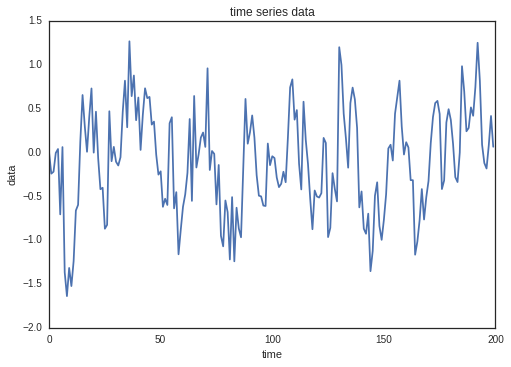

In [4]:
# Here is the data
y=np.array([0.00000000e+00,  -2.41884381e-01,  -2.19815584e-01, -5.92654275e-03,   3.89498469e-02,  -7.06374756e-01,
         6.09244734e-02,  -1.36663360e+00,  -1.63887006e+00, -1.31721354e+00,  -1.52424274e+00,  -1.23902096e+00,
        -6.63029664e-01,  -5.97693396e-01,   1.26359198e-01, 6.55116724e-01,   2.98253859e-01,   7.19461104e-03,
         4.04113046e-01,   7.29893878e-01,  -1.96731327e-03, 4.64230686e-01,  -6.79727540e-02,  -4.19137503e-01,
        -4.03256074e-01,  -8.70131096e-01,  -8.25921060e-01, 4.69417714e-01,  -1.00177377e-01,   6.34076840e-02,
        -1.05978178e-01,  -1.48916430e-01,  -5.43573786e-02, 4.61970441e-01,   8.18280558e-01,   2.87185308e-01,
         1.26715777e+00,   6.41828280e-01,   8.77364512e-01, 3.67214345e-01,   6.26413729e-01,   2.87102039e-02,
         4.28449069e-01,   7.31450267e-01,   6.19131504e-01, 6.33373751e-01,   3.17572088e-01,   3.51692600e-01,
        -2.48995087e-02,  -2.53030153e-01,  -2.15503832e-01,-6.20238803e-01,  -5.28176551e-01,  -5.99112522e-01,
         3.32834574e-01,   4.01426008e-01,  -6.37956657e-01,-4.52884655e-01,  -1.16203988e+00,  -8.82257305e-01,
        -6.19309194e-01,  -4.78009274e-01,  -2.32960888e-01, 3.80860392e-01,  -5.52337194e-01,   6.43589528e-01,
        -1.71939822e-01,  -2.22714248e-02,   1.69698173e-01, 2.26875861e-01,   6.27784254e-02,   9.59070565e-01,
        -2.00412521e-01,   1.62853318e-02,  -1.64492388e-02,-5.92514844e-01,  -1.43386816e-01,  -9.50829381e-01,
        -1.07109089e+00,  -5.47941202e-01,  -6.80501959e-01,-1.22073393e+00,  -5.09858830e-01,  -1.24176275e+00,
        -6.30383282e-01,  -8.67182207e-01,  -9.67761290e-01,-1.79674059e-01,   6.09919157e-01,   9.95635469e-02,
         2.28199545e-01,   4.21792446e-01,   1.69467875e-01,-2.59645693e-01,  -4.93207819e-01,  -5.01539736e-01,
        -6.05873935e-01,  -6.11037064e-01,   1.01647103e-01,-1.44991643e-01,  -4.33238432e-02,  -6.41062073e-02,
        -2.85514261e-01,  -3.95586179e-01,  -3.57194799e-01,-2.20170569e-01,  -3.39918202e-01,   1.70035788e-01,
         7.41558107e-01,   8.33120964e-01,   3.73995334e-01, 4.83141624e-01,  -1.28861162e-01,  -4.22192149e-01,
         5.78378631e-01,   1.43550174e-01,  -1.31226657e-01,-5.30885377e-01,  -8.76270272e-01,  -4.34154230e-01,
        -5.02379201e-01,  -5.14585915e-01,  -4.64397849e-01, 1.65475660e-01,   1.07774616e-01,  -9.65587168e-01,
        -8.60566293e-01,  -2.36405434e-01,  -4.12606502e-01,-5.58566210e-01,   1.20028400e+00,   9.96896069e-01,
         4.41653164e-01,   1.59249052e-01,  -1.74168536e-01, 5.63049814e-01,   7.39366310e-01,   6.05361272e-01,
         2.79509214e-01,  -6.26883609e-01,  -4.44982987e-01,-8.69359696e-01,  -9.27422224e-01,  -6.98179880e-01,
        -1.35445853e+00,  -1.12329955e+00,  -4.94572306e-01,-3.40507834e-01,  -8.37907253e-01,  -9.97003760e-01,
        -7.69088724e-01,  -4.77378429e-01,   4.52315984e-02, 8.76114754e-02,  -9.24336169e-02,   4.42178858e-01,
         6.32190755e-01,   8.18383124e-01,   2.95975304e-01,-2.38797237e-02,   1.16395924e-01,   5.62311884e-02,
        -3.15966789e-01,  -3.16808474e-01,  -1.16651970e+00,-1.01729199e+00,  -7.75285712e-01,  -4.17618624e-01,
        -7.65156825e-01,  -5.10469718e-01,  -3.25334859e-01, 1.06358791e-01,   4.03467712e-01,   5.62837155e-01,
         5.87793605e-01,   4.38191557e-01,  -4.17879322e-01,-3.19715350e-01,   3.41624528e-01,   4.93054502e-01,
         3.69746949e-01,   9.62398763e-02,  -2.81485049e-01,-3.37776564e-01,  -1.30858217e-03,   9.83538405e-01,
         6.94986165e-01,   2.41137851e-01,   2.79478944e-01, 5.13500357e-01,   4.17786188e-01,   7.46707509e-01,
         1.25038407e+00,   8.17699739e-01,   8.78811468e-02,-1.20413802e-01,  -1.83227208e-01,   8.06195706e-02,
         4.16043086e-01,   6.45585187e-02])
fig = plt.plot(y)
plt.title('time series data')
plt.xlabel('time')
plt.ylabel('data')


In [18]:
#PART 1: MLE
y_yn1 = y[0:-1]*y[1:]
yn1_yn1 = y[0:-1]**2
alpha = np.sum(y_yn1) / np.sum(yn1_yn1)
print 'MLE solution estimates alpha = ', alpha

#PART 2: infer sigma^2 and alpha using pymc
sigma_square = pm.Uniform('sigma_square',0,10)
alpha = pm.Uniform('alpha',-5,5)

#?pm.normal_like

@pm.observed
def log_likelihood(value = y, ss = sigma_square, a = alpha):
    log_prob = 0
    
    for i in range(value.shape[0]-1):
        log_prob += pm.normal_like(y[i+1]-a*y[i],0,1/ss)
        
    return log_prob

model = pm.Model([sigma_square,alpha,log_likelihood])
p_mcmc = pm.MCMC(model)
p_mcmc.sample(iter = 5000, burn =100, thin =10)

print 'pymc finishes...'



#likelihood = pm.Normal('likelihood',mu=0, tau = 1/sigma_square,value= y[1:] - alpha* y[0:-1],observed = True)


MLE solution estimates alpha =  0.681646977553
 [-----------------100%-----------------] 5000 of 5000 complete in 5.3 sec

pymc posterior estimates mean of alpha is: 0.678244845435
pymc posterior estimates mean of sigma_square is: 0.196138275887


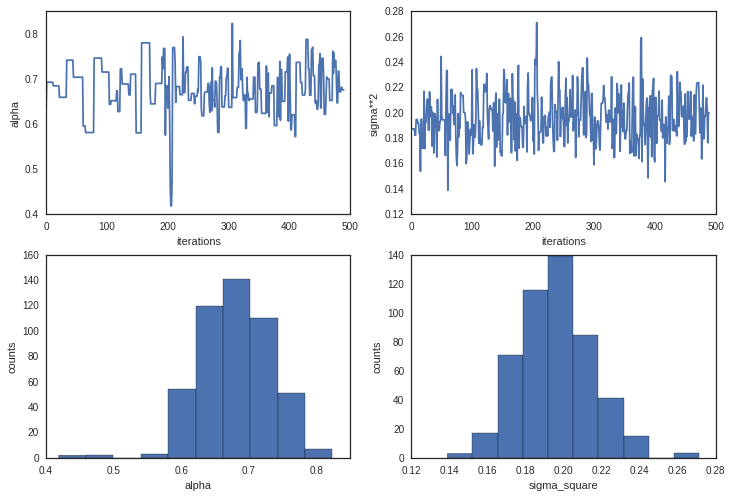

In [35]:
#PART 2 cont
#plot solution
fig1 = plt.figure(figsize = [12,8])
plt.subplot(2,2,1)
plt.xlabel('iterations')
plt.ylabel('alpha')
plt.plot(alpha.trace())

plt.subplot(2,2,2)
plt.xlabel('iterations')
plt.ylabel('sigma**2')
plt.plot(sigma_square.trace())

plt.subplot(2,2,3)
plt.xlabel('alpha')
plt.ylabel('counts')
plt.hist(alpha.trace())

plt.subplot(2,2,4)
plt.xlabel('sigma_square')
plt.ylabel('counts')
plt.hist(sigma_square.trace())

print 'pymc posterior estimates mean of alpha is:', np.mean(alpha.trace())
print 'pymc posterior estimates mean of sigma_square is:',  np.mean(sigma_square.trace())

In [34]:
# predict 3 steps ahead:

# we use sampled alpha's to predict y_t+1
sample_len = sigma_square.trace().shape[0]
sample_sigma = np.sqrt(sigma_square.trace())

y_tp1 = alpha.trace() * y[-1] +  sample_sigma * np.random.randn(sample_len)
print 'y_tp1 prediction =', np.mean(y_tp1)

# we use y_t+1 to estimate y_t+2
y_tp2 = np.zeros((y_tp1.shape[0],y_tp1.shape[0]),dtype = 'float')
for i in xrange(y_tp1.shape[0]):
    y_tp2[i,:] = alpha.trace() * y_tp1[i] +  sample_sigma * np.random.randn(sample_len)
    
print 'y_tp2 prediction =', y_tp2.mean()

#finally, we use y_t+2 to predict y_t+3
y_tp3 = np.zeros((y_tp1.shape[0],y_tp1.shape[0],y_tp1.shape[0]),dtype = 'float')
for i in xrange(y_tp1.shape[0]):
    for j in xrange(y_tp1.shape[0]):
        y_tp3[i,j,:] = alpha.trace() * y_tp2[i,j] +  sample_sigma * np.random.randn(sample_len)
    
print 'y_tp3 prediction =', y_tp3.mean()


y_tp1 prediction = 0.077989509821
y_tp2 prediction = 0.0520614384326
y_tp3 prediction = 0.0352850937647


# Extra Problem 4: Final Project Proposal 

Think about your final project proposal. Your final project is your chance to show off what you learned in AM207! You have seen a lot of different models and examples in lecture and in the homework assignments. In your final project you are free to apply all the techniques you learned to an area of your choice. Be careful not to choose data that you still need to label yourself or that will take you ages to clean. The main focus should be on finding a good model and comparing different techniques for sampling, optimization, etc. 

Please note that there will be a google spreadsheet where you can submit your final project proposal abstract. No need to write it into this notebook. 

The abstract should be short, but contain a short description of your final project idea, which methods you are planning on using, and where your data will come from. 

Please see our proposal at the following link:

https://github.com/jeewon-hwang/2016am207_final_project/blob/master/final_project_proposal.pdf